In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
import math
import albumentations as A
import matplotlib.pyplot as plt

#### Model

In [2]:
f_mnist_model = tf.keras.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28 ,1)),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(350,activation='relu'),
    layers.Dense(150, activation='relu'),
    Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

f_mnist_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.00000001)

#### Data preparation.
The Fashion_Mnist data is created as follows: 60,000 training examples and 10,000 test examples.
On the training set (60,000) I will perform the augmentation technique. I will create additional data. In total, the training dataset will be twice as large. I will then divide the combined dataset into a training and validation sets in a ratio of 0.9 to 0.1. Based on this data, I will train a model.
I leave the test set to test the trained model.

In [3]:
def augmentation (data):

    augmented_images = []

    for image in data:
      transform1 = A.HorizontalFlip(p=0.5)
      transform2 = A.RandomRotate90()
      transform3 = A.Transpose()
      transform4 = A.Blur(blur_limit=3)
      transform5 = A.OpticalDistortion()
      transform6 = A.GridDistortion()
      augmented_image = transform1(image=image)['image']
      augmented_image = transform2(image=image)['image']
      augmented_image = transform3(image=image)['image']
      augmented_image = transform4(image=image)['image']
      augmented_image = transform5(image=image)['image']
      augmented_image = transform6(image=image)['image']

      augmented_images.append(augmented_image)
    
    images = np.array(augmented_images)
    return images

In [4]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
images_aug = augmentation(images)

images_transformed = np.concatenate((images_aug, images), axis=0)
labels_transformed = np.concatenate((labels, labels), axis=None)

In [6]:
print(images_transformed.shape)
print(labels_transformed.shape)

(120000, 28, 28)
(120000,)


In [7]:
X_train, X_val, y_train, y_val = \
    train_test_split(images_transformed, labels_transformed, test_size=0.1, random_state=4321, stratify=labels_transformed)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(128)

train_stats = f_mnist_model.fit(train_ds, epochs=85,callbacks=[reduce_lr],validation_data=(X_val, y_val))

Epoch 1/85
844/844 [==============================] - 17s 6ms/step - loss: 0.6785 - accuracy: 0.7450 - val_loss: 0.4054 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 2/85
844/844 [==============================] - 5s 6ms/step - loss: 0.4459 - accuracy: 0.8346 - val_loss: 0.3342 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 3/85
844/844 [==============================] - 6s 7ms/step - loss: 0.3908 - accuracy: 0.8554 - val_loss: 0.3030 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 4/85
844/844 [==============================] - 5s 6ms/step - loss: 0.3591 - accuracy: 0.8669 - val_loss: 0.2767 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 5/85
844/844 [==============================] - 6s 7ms/step - loss: 0.3354 - accuracy: 0.8753 - val_loss: 0.2692 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/85
844/844 [==============================] - 5s 6ms/step - loss: 0.3208 - accuracy: 0.8811 - val_loss: 0.2587 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/85
844/844 [==============================] - 6s 7ms/step - l

#### Model accuracy
Based on test data from the original (non-augmented) Fashion_Mnist dataset

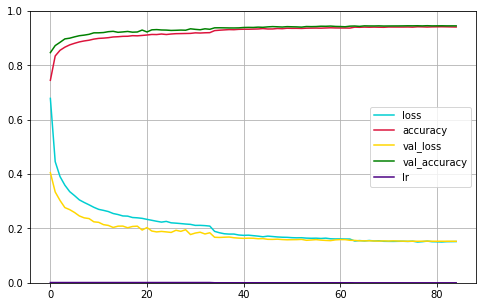

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(train_stats.history).plot(figsize=(8, 5),color=['darkturquoise', 'crimson', 'gold', 'green', 'indigo'])
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [9]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = test
images = images/255.0
labels = labels.astype(np.int32)
score = f_mnist_model.evaluate(images, labels)
score

313/313 [==============================] - 1s 3ms/step - loss: 0.2018 - accuracy: 0.9316


[0.20179516077041626, 0.9315999746322632]

In [10]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
X_test, y_test = test
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred = f_mnist_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


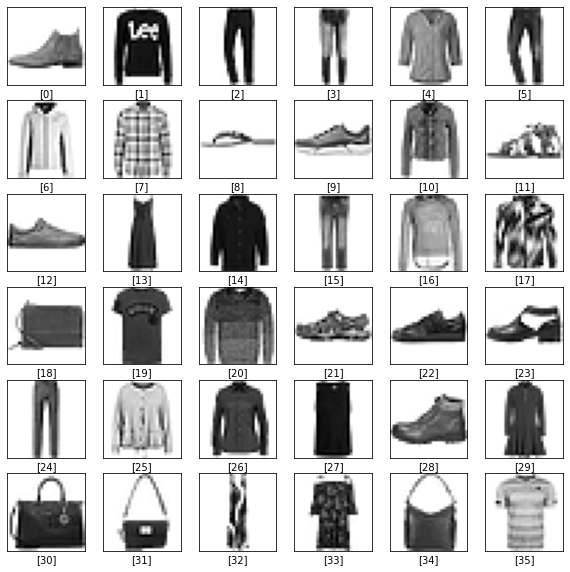

In [11]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel([i])

plt.show()

In [12]:
dataset = list(range(0,36))

In [13]:
def what_is_it():
    no_img = int(input("Which photo would you like to identify? Enter a number between 0-35"))
    while no_img not in dataset:
        no_img = int(input("Enter a number between 0-35."))
    num = np.argmax(y_pred[no_img])
    print("class :",class_names[num])
    print("(to be sure: the real class is...", class_names[y_test[no_img]],")")

In [14]:
what_is_it()

Which photo would you like to identify? Enter a number between 0-3532
class : Dress
(to be sure: the real class is... Dress )


#### Conclusions:

I think it's not bad. The model was sometimes overtrained, so in order to alleviate this situation, I used Dropout() in the model.

On the Internet (at least where I reached) rarely anyone pays attention to accuracy on test data. It is enough that the model trained on the training data has high accuracy and no attention is paid to overtraining of the model. In these circumstances, I consider the achievement of accuracy ~.93 by a layman (i.e. me) on test data as a success.